In [77]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
import os


import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Setup: Get EB prior

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

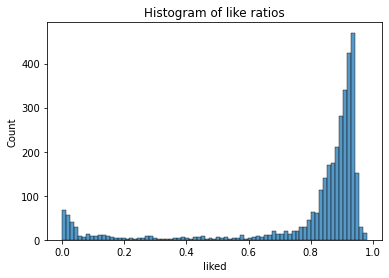

In [6]:
_ = sns.histplot(video_df).set(title='Histogram of like ratios')

In [7]:
def transform_values(i,n,prior=1/2):
    return (i*(n-1)+prior)/n

In [8]:
prior_a, prior_b, loc, scale = beta.fit([transform_values(i, len(train_videos.values),1/2)
                                          for i in train_videos.values], floc=0, fscale=1)

In [9]:
prior_a *= 10
prior_b *= 10
print(prior_a, prior_b)

14.270965891341989 5.916156493565227


## Load in and sanitize simulation results

In [207]:
dir_dict = {'sims_opt': 'optimistic', 'sims_standard': 'standard', 'sims_strong': 'strong'}

In [208]:
data_dict = dict()

for val in [0.0, 0.3, 0.7, 1.0]:
    for k in dir_dict:
        data_dict[(val, dir_dict[k])] = np.load(f'{k}/sim_data_alpha_{val}.npy',allow_pickle=True)[()]
        for l in copy.deepcopy(list(data_dict[(val,dir_dict[k])].keys())):
            if type(l)==tuple:
                data_dict[(val,dir_dict[k])][l[0]] = data_dict[(val,dir_dict[k])].pop(l)

In [209]:
# there has to be a more efficient way to process this data!

market_dict = dict()

for val in [0.0, 0.3, 0.7, 1.0]:
    for k in dir_dict:
        print(f"processing key {(val, k)}")
        market_data = np.load(f'{k}/market_id_data_{val}.npy',allow_pickle=True)[()].astype(float)
        market_dict[(val, dir_dict[k])] = market_data
#         for i in range(market_data.shape[0]):
#             for j in range(market_data.shape[1]):
#                 market_data[i,j] = video_df[market_data[i,j]]
#         market_dict[(val,dir_dict[k])] = np.max(market_data,axis=1)

processing key (0.0, 'sims_opt')
processing key (0.0, 'sims_standard')
processing key (0.0, 'sims_strong')
processing key (0.0, 'soal_sims')


FileNotFoundError: [Errno 2] No such file or directory: 'soal_sims/market_id_data_0.0.npy'

In [92]:
market_dict_top_item = dict()

for val in [0.0, 0.3, 0.7, 1.0]:
    for k in dir_dict:
        print(f"processing key {(val, k)}")
        market_data = np.load(f'{k}/market_id_data_{val}.npy',allow_pickle=True)[()].astype(float)
        market_dict_top_item[(val, dir_dict[k])] = market_data
        for i in range(market_data.shape[0]):
            for j in range(market_data.shape[1]):
                market_data[i,j] = video_df[market_data[i,j]]
        market_dict_top_item[(val,dir_dict[k])] = np.max(market_data,axis=1)

processing key (0.0, 'sims_opt')
processing key (0.0, 'sims_standard')
processing key (0.0, 'sims_strong')
processing key (0.3, 'sims_opt')
processing key (0.3, 'sims_standard')
processing key (0.3, 'sims_strong')
processing key (0.7, 'sims_opt')
processing key (0.7, 'sims_standard')
processing key (0.7, 'sims_strong')
processing key (1.0, 'sims_opt')
processing key (1.0, 'sims_standard')
processing key (1.0, 'sims_strong')


## Plotting the central figure that we want to base our results on - the pareto curve

In [13]:
def gini_coeff(a):
    temp = np.sort(a)
    n = temp.shape[0]
    counts = np.array(range(1,n+1))
    asum = np.sum(temp)
    return 1/n*(n+1 - 2*((n+1)*np.sum(temp) - temp @ counts)/asum)

In [14]:
def get_quality_array(datadict, value_df):
    a = []
    for l in datadict:
        for life in datadict[l]:
            a.append(np.array([value_df[l]]*(int(np.round(np.sum(life[-1,:]) - np.sum(life[0,:]))))))
            
    return np.hstack(a)

In [15]:
def get_plays_array(datadict):
    a = []
    for l in datadict:
        for lifespan in datadict[l]:
            final_score = lifespan[-1]
            a.append((final_score[0] + final_score[1] - np.sum(lifespan[0]))/lifespan.shape[0])
            
    return np.array(a)

In [179]:
def get_average_plays_variance(datadict):
    a = []
    for l in datadict:
        l_array = []
        for lifespan in datadict[l]:
            l_array.append((np.sum(lifespan[-1]) - np.sum(lifespan[0]))/(lifespan.shape[0]-1))
        
        a.append(np.std(l_array))
        
    return np.mean(a)


In [180]:
np.argmax(video_df[market_dict[(0.0, 'strong')][0,:]])

1

In [181]:
def get_plays_dict_from_market_data(marketdict, video_df):
    datadict = {}
    prev_mkt = marketdict[0,:]
    counts = [[0] for _ in range(marketdict.shape[1])]
    for i in range(marketdict.shape[0]):
        if (i+1) % (marketdict.shape[0]//20) == 0:
            print(f'iteration {i+1}/{marketdict.shape[0]}')
        curr_market = marketdict[i,:]
        best_vid_index = np.argmax(video_df[curr_market])
        for j in range(marketdict.shape[1]):
            if marketdict[i,j] not in datadict:
                datadict[marketdict[i,j]] = []
            
            if marketdict[i,j] != prev_mkt[j]:
                datadict[prev_mkt[j]].append(np.array(counts[j]))
                counts[j] = [0]
                
            if j == best_vid_index:
                counts[j].append(copy.deepcopy(counts[j][-1])+1)
            else:
                counts[j].append(copy.deepcopy(counts[j][-1]))
                
        prev_mkt = curr_market
        
    for j in range(marketdict.shape[1]):
        datadict[prev_mkt[j]].append(np.array(counts[j]))
        
    return datadict
                
            
            
            

In [182]:
market_plays_dict = get_plays_dict_from_market_data(market_dict[(0.0,'standard')],video_df)

iteration 50000/1000000
iteration 100000/1000000
iteration 150000/1000000
iteration 200000/1000000
iteration 250000/1000000
iteration 300000/1000000
iteration 350000/1000000
iteration 400000/1000000
iteration 450000/1000000
iteration 500000/1000000
iteration 550000/1000000
iteration 600000/1000000
iteration 650000/1000000
iteration 700000/1000000
iteration 750000/1000000
iteration 800000/1000000
iteration 850000/1000000
iteration 900000/1000000
iteration 950000/1000000
iteration 1000000/1000000


In [183]:
for k in copy.deepcopy(list(market_plays_dict.keys())):
    market_plays_dict[int(k)] = market_plays_dict.pop(k)

In [184]:
df_list = []
for k in data_dict:
    pareto_df = pd.DataFrame()
    prior_a, prior_b = data_dict[k][list(data_dict[k].keys())[0]][0][0,:]
    total_val, total_plays = 0, 0
    
#     pareto_df = pd.DataFrame([[k[0], 
#                               k[1],
#                               prior_a, 
#                               prior_b, 
#                               np.sum(market_dict[k] - get_quality_array(data_dict[k], video_df)),
#                               gini_coeff(get_plays_array(data_dict[k]))]],
#                               columns=['eta', 'dataset', 'prior_a', 'prior_b', 'regret', 'gini_coeff'])

    pareto_df = pd.DataFrame([[k[0], 
                              k[1],
                              prior_a, 
                              prior_b, 
                              np.sum(market_dict_top_item[k] - get_quality_array(data_dict[k], video_df)),
                              get_average_plays_variance(data_dict[k])]],
                              columns=['eta', 'dataset', 'prior_a', 'prior_b', 'regret', 'var'])
    
    df_list.append(pareto_df)

In [185]:
oracle_df = pd.DataFrame([[0, 
                           'oracle',
                           0, 
                           0, 
                           0,
                           get_average_plays_variance(market_plays_dict)]],
                           columns=['eta', 'dataset', 'prior_a', 'prior_b', 'regret', 'var'])

In [204]:
pareto_df = pd.concat(df_list + [oracle_df])

In [205]:
pareto_df = pareto_df.reset_index().drop(index=[0,1])
pareto_df

,index,eta,dataset,prior_a,prior_b,regret,var
2,0,0.0,strong,1.000000,1.000000,54534.876711,0.095398
3,0,0.3,optimistic,1.128129,0.877485,56298.775910,0.097315
4,0,0.3,standard,4.981290,2.474847,58058.092916,0.090181
5,0,0.3,strong,3.700000,3.700000,52150.826348,0.103593
6,0,0.7,optimistic,1.298968,0.714131,58611.914684,0.103638
7,0,0.7,standard,10.289676,4.441310,61168.828344,0.089871
8,0,0.7,strong,7.300000,7.300000,55896.051091,0.108252
9,0,1.0,optimistic,1.427097,0.591616,60335.918033,0.108679
10,0,1.0,standard,14.270966,5.916156,63164.557368,0.089358
11,0,1.0,strong,10.000000,10.000000,58618.834321,0.108776


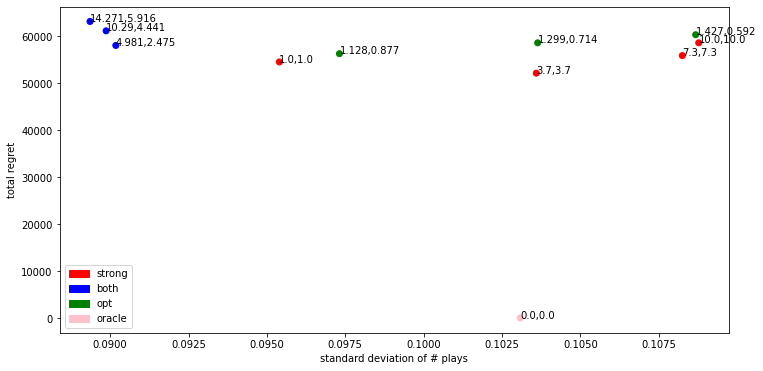

In [206]:


x = list(pareto_df['var'])
y = list(pareto_df['regret'])
colors = list(pareto_df['dataset'])

color_dict = {"standard":"blue", "strong":"red", "optimistic":"green", 'oracle':"pink"}

fig,ax = plt.subplots()
fig.set_size_inches(12,6)
ax.scatter(x, y, color=[color_dict[item] for item in colors])
plt.xlabel('standard deviation of # plays')
plt.ylabel('total regret')

labels = pareto_df[['prior_a', 'prior_b']].to_numpy()

red_patch = mpatches.Patch(color='red', label='strong')
blue_patch = mpatches.Patch(color='blue', label='both')
green_patch = mpatches.Patch(color='green', label='opt')
pink_patch = mpatches.Patch(color='pink', label='oracle')
plt.legend(handles=[red_patch, blue_patch, green_patch, pink_patch])

for i in range(labels.shape[0]):
    ax.annotate(f"{np.round(labels[i,0],3)},{np.round(labels[i,1],3)}", (x[i], y[i]))

In [189]:
video_df[market_plays_dict.keys()].sort_values().tail()

video_id
4659     0.941818
3118     0.946137
4685     0.946137
10462    0.952620
1452     0.956903
Name: liked, dtype: float64

In [190]:
np.std([item[-1] - item[0] for item in market_plays_dict[1452]])

103.28672219131722

In [196]:
np.std([(item[-1] - item[0])/(item.shape[0]-1) for item in market_plays_dict[4659]])

0.39062448044863196